In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import os
import copy
import pickle

In [3]:
# Hao L1 celltypes
types = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

## Read PreLect features

In [4]:
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/feature_selection_k3')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [5]:
features_dict.keys()

dict_keys(['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T'])

In [6]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,19,10
CD4_T,201,95
CD8_T,23,9
DC,50,23
Mono,50,20
NK,33,17
other,5,3
other_T,247,112


## Read Stuart dataset

In [7]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
# adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')

print('Original adata:', adata.shape)

Original adata: (161764, 33538)


In [8]:
# bmcite = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\Stuart_bm\Stuart_bmcite_RNAassay_original.h5ad")
bmcite = sc.read_h5ad(dataset_dir / 'Stuart_bm/Stuart_bmcite_RNAassay_original.h5ad')
bmcite.shape

(30672, 17009)

In [13]:
bmcite.var.head()

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,var.features,var.features.rank
FO538757.2,0.079649,0.085175,0.104525,0.814878,False,NaN,-2147483648
AP006222.2,0.019334,0.020460,0.021929,0.933021,False,NaN,-2147483648
RP4-669L17.10,0.000945,0.000945,0.001012,0.933808,False,NaN,-2147483648
RP11-206L10.9,0.015682,0.015632,0.017621,0.887135,False,NaN,-2147483648
LINC00115,0.004727,0.004836,0.005287,0.914594,False,NaN,-2147483648


In [18]:
bmcite_genes = bmcite.var_names.tolist()
hao_genes = adata.var_names.tolist()
common_genes = list(set(bmcite_genes) & set(hao_genes))
print('Common genes:', len(common_genes))
missing_genes = list(set(bmcite_genes) - set(hao_genes))
print('Missing genes:', len(missing_genes))

Common genes: 14337
Missing genes: 2672


In [43]:
# PreLect genes used to train LR model
celltype = 'B'
train_genes = features_dict[celltype]['Gene'].tolist() 
query_genes = bmcite.var_names.tolist()
common_genes = list(set(train_genes) & set(query_genes))

# Create a full matrix for query data, initializing with zeros for missing genes
X_query_full = np.zeros((bmcite.shape[0], len(train_genes)))
# Fill in the values for the common genes
for i, gene in enumerate(train_genes):
    if gene in common_genes:
        X_query_full[:, i] = bmcite[:, gene].X.toarray().flatten()
    else:
        print('Missing', gene)

X_query_full.shape

(30672, 19)

In [50]:
def predict_celltype_w_symbol(LR_model, query_adata, features_dict, celltype):
    # PreLect features (symbol)
    train_genes = features_dict[celltype]['Gene'].tolist()
    print('Train genes (top10):', train_genes[:10])

    # PreLect features (symbol) have 9 intersectoin with Zheng (symbol)
    query_genes = query_adata.var_names.tolist()
    common_genes = list(set(train_genes) & set(query_genes))
    missing_genes = list(set(train_genes) - set(query_genes))
    print('No. common genes:', len(common_genes))
    print('Common genes (top10):', common_genes[:10])
    print('No. missing genes:', len(missing_genes))
    print('Missing genes:', missing_genes)

    # Create a full matrix for query data, initializing with zeros for missing genes
    X_query_full = np.zeros((query_adata.shape[0], len(train_genes)))
    # Fill in the values for the common genes
    for i, gene in enumerate(train_genes):
        if gene in common_genes:
            X_query_full[:, i] = query_adata[:, gene].X.toarray().flatten()

    # predict on query dataset
    y_query_pred = LR_model.predict(X_query_full)
    print('Prediction = 1:', sum(y_query_pred == 1))  # predict celltype 的有幾個

    # Get the probability of individual cell predicting as the positive class
    y_query_prob = LR_model.predict_proba(X_query_full)[:, 1]  # Probability for the positive class (class 1)
    print('Probability > 0.5:', sum(y_query_prob > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype

    return y_query_pred, y_query_prob

In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\LR_likelihood\LR_model')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/LR_likelihood/LR_model')

celltype = 'B'
with open(f'LRclassifier_{celltype}_l1.pkl', 'rb') as f:
    lr_model = pickle.load(f)

y_pred_B, y_prob_B = predict_celltype_w_symbol(lr_model, bmcite, features_dict, celltype)

Train genes (top10): ['S100A4', 'RALGPS2', 'PTPRC', 'IGKC', 'BANK1', 'CD74', 'HLA-DRA', 'ACTB', 'TMSB4X', 'MS4A1']
No. common genes: 19
Common genes (top10): ['ACTB', 'CD79A', 'CD79B', 'TMSB4X', 'RALGPS2', 'IGLC2', 'FTH1', 'B2M', 'IGHM', 'MS4A1']
No. missing genes: 0
Missing genes: []
Prediction = 1: 4045
Probability > 0.5: 4045


In [52]:
prediction_dict = {}
likelihood_dict = {}

for celltype in types:
    print(celltype, '=====================')
    with open(f'LRclassifier_{celltype}_l1.pkl', 'rb') as f:
        lr_model = pickle.load(f)
    
    y_pred_celltype, y_prob_celltype = predict_celltype_w_symbol(lr_model, bmcite, features_dict, celltype)
    prediction_dict[celltype] = y_pred_celltype
    likelihood_dict[celltype] = y_prob_celltype

B =====================
Train genes (top10): ['S100A4', 'RALGPS2', 'PTPRC', 'IGKC', 'BANK1', 'CD74', 'HLA-DRA', 'ACTB', 'TMSB4X', 'MS4A1']
No. common genes: 19
Common genes (top10): ['ACTB', 'CD79A', 'CD79B', 'TMSB4X', 'RALGPS2', 'IGLC2', 'FTH1', 'B2M', 'IGHM', 'MS4A1']
No. missing genes: 0
Missing genes: []
Prediction = 1: 4045
Probability > 0.5: 4045
CD4_T =====================
Train genes (top10): ['RPL11', 'SH3BGRL3', 'CD52', 'NDUFS5', 'SMAP2', 'YBX1', 'UQCRH', 'SERBP1', 'CD2', 'TXNIP']
No. common genes: 195
Common genes (top10): ['ACTB', 'CD2', 'IL6ST', 'SEPT7', 'PIP4K2A', 'HMGB2', 'RPS25', 'CD27', 'ARGLU1', 'ID2']
No. missing genes: 6
Missing genes: ['NSD3', 'RPS4Y1', 'NOP53', 'ATP5MC2', 'FYB1', 'RIPOR2']
Prediction = 1: 8410
Probability > 0.5: 8410
CD8_T =====================
Train genes (top10): ['S100A4', 'H3F3A', 'CD8A', 'CD8B', 'PTMA', 'ARL4C', 'CD74', 'LTB', 'ACTB', 'TRBC2']
No. common genes: 23
Common genes (top10): ['ACTB', 'PTMA', 'IL32', 'MT-CO3', 'TMSB4X', 'MT-CO1', 'F

In [53]:
prediction_df = pd.DataFrame(prediction_dict)
likelihood_df = pd.DataFrame(likelihood_dict)
prediction_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0


In [54]:
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,0.000103,3.485857e-04,0.001162,5.997201e-04,0.001128,2.639099e-04,0.081501,3.064187e-04
1,0.000020,8.743816e-01,0.002481,1.290452e-07,0.000146,1.209813e-04,0.003606,1.532057e-02
2,0.001646,9.724371e-01,0.058082,1.984851e-09,0.000101,9.995893e-06,0.000452,1.319097e-04
3,0.000523,9.999947e-01,0.105587,4.677811e-10,0.000277,3.114533e-07,0.000352,1.604018e-04
4,0.000007,3.929243e-07,0.000046,1.496582e-06,0.979119,2.567073e-04,0.005092,7.867028e-07


In [77]:
# Assign predicted celltype with max likelihood
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

bmcite.obs['Pred_LR_L1'] = assignments
bmcite.obs['LR_likelihood'] = largest_values
bmcite.obs.head()

,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight,Pred_LR_L1,LR_likelihood
a_AAACCTGAGCTTATCG-1,7546.0,2136,1350.0,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.482701,other,0.081501
a_AAACCTGAGGTGGGTT-1,1029.0,437,2970.0,25,HumanHTO1,batch1,T cell,gdT,0.241789,CD4_T,0.874382
a_AAACCTGAGTACATGA-1,1111.0,429,2474.0,23,HumanHTO5,batch1,T cell,CD4 Naive,0.507714,CD4_T,0.972437
a_AAACCTGCAAACCTAC-1,2741.0,851,4799.0,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308,CD4_T,0.999995
a_AAACCTGCAAGGTGTG-1,2099.0,843,5434.0,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.568508,Mono,0.979119


## Prediction confusion matrix

In [81]:
a = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other_T']  # PreLect LR model predicted
b = ['B cell', 'T cell', 'T cell', 'Mono/DC', 'Mono/DC', 'NK', 'T cell']  # true labels from bmcite
# Hao dataset does not include progenitor cell, so it is impossible to correctly predict them in bmcite

# {predicted: true}
type_reference = dict(zip(a, b))
type_reference

{'B': 'B cell',
 'CD4_T': 'T cell',
 'CD8_T': 'T cell',
 'DC': 'Mono/DC',
 'Mono': 'Mono/DC',
 'NK': 'NK',
 'other_T': 'T cell'}

In [83]:
# pred_main['converted_labels'] = None
for cell in bmcite.obs_names:
    if bmcite.obs.loc[cell, 'Pred_LR_L1'] in type_reference:
        bmcite.obs.loc[cell, 'converted_labels'] = type_reference[bmcite.obs.loc[cell, 'Pred_LR_L1']]
    else:
        bmcite.obs.loc[cell, 'converted_labels'] = bmcite.obs.loc[cell, 'Pred_LR_L1']
bmcite.obs.head()

,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight,Pred_LR_L1,LR_likelihood,converted_labels
a_AAACCTGAGCTTATCG-1,7546.0,2136,1350.0,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.482701,other,0.081501,other
a_AAACCTGAGGTGGGTT-1,1029.0,437,2970.0,25,HumanHTO1,batch1,T cell,gdT,0.241789,CD4_T,0.874382,T cell
a_AAACCTGAGTACATGA-1,1111.0,429,2474.0,23,HumanHTO5,batch1,T cell,CD4 Naive,0.507714,CD4_T,0.972437,T cell
a_AAACCTGCAAACCTAC-1,2741.0,851,4799.0,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308,CD4_T,0.999995,T cell
a_AAACCTGCAAGGTGTG-1,2099.0,843,5434.0,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.568508,Mono,0.979119,Mono/DC


In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\Stuart_bm_annotate\Predict_w_Hao_LR')
os.chdir(source_code_dir / 'Stuart_bm_annotate/Predict_w_Hao_LR')
bmcite.obs.to_csv('PreLect_LR_L1_prediction_obs.csv')

In [87]:
true_labels = bmcite.obs['celltype.l1']
predicted_labels = bmcite.obs['converted_labels']

cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['PreLect LR model predicted'], margins=False)
row_order = cm.index.tolist()
row_order.append(row_order.pop(row_order.index('Progenitor cells')))
cm = cm.reindex(row_order, axis=0)
cm

PreLect LR model predicted,B cell,Mono/DC,NK,T cell,other
True,,,,,
B cell,3728,5,0,14,6
Mono/DC,24,7667,0,25,13
NK,4,8,1337,59,2
T cell,98,7,53,14687,56
Progenitor cells,461,790,16,82,1530


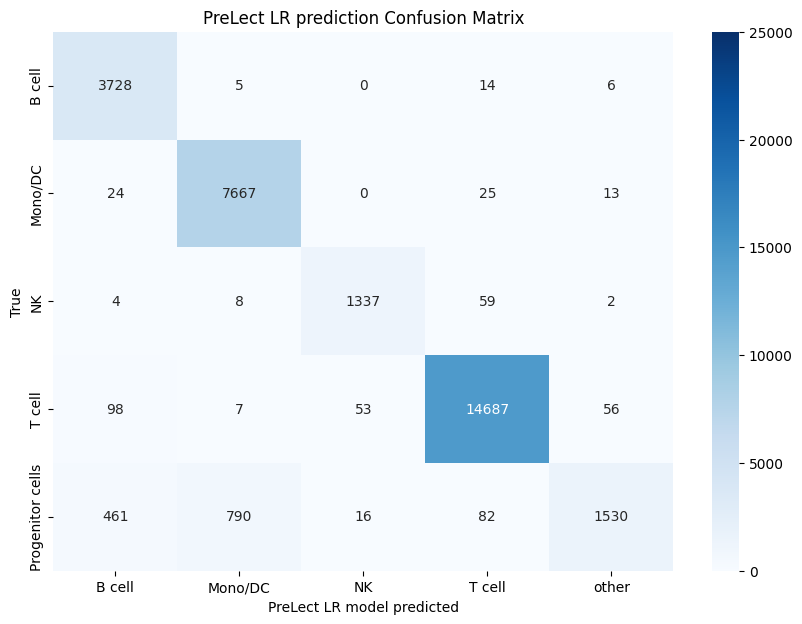

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('PreLect LR prediction Confusion Matrix')
plt.show()

In [89]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

method = ['micro', 'macro', 'weighted']
for m in method:
    precision = precision_score(true_labels, predicted_labels, average=m)
    print(f"{m} Precision:", precision)
    f1 = f1_score(true_labels, predicted_labels, average=m)
    print(f"{m} F1 Score:", f1)

Accuracy: 0.8939423578508086
micro Precision: 0.8939423578508086
micro F1 Score: 0.8939423578508086
macro Precision: 0.6178712508461287


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


macro F1 Score: 0.6344459519792847
weighted Precision: 0.8572743311819973
weighted F1 Score: 0.8745472537010024
weighted F1 Score: 0.8745472537010024
